# 🏋️‍♀️Fitness identifier Iteratie 6

In [5]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

<h2 style="font-size:20px; color:#3B82F6;">Inleiding</h2>

In deze derde iteratie heb ik samen met mijn docent Bas Michielsen gereflecteerd op de structuur en werkwijze van mijn project. Tijdens ons gesprek hebben we besproken dat ik in de eerste versie dezelfde afbeeldingen gebruikte voor zowel training, validatie als testen. Dit zorgde ervoor dat mijn resultaten niet betrouwbaar waren. Bas adviseerde mij om dit proces voortaan automatisch te laten uitvoeren met code, zodat de dataset op een correcte manier wordt opgesplitst in train-, validatie- en testsets.

Daarnaast hebben we gekeken naar de lange trainingstijden binnen mijn model. Een mogelijke oplossing hiervoor is om de afbeeldingen te verkleinen, waardoor het trainen en testen sneller en efficiënter kan verlopen.

Opvallend was dat mijn testresultaten (accuracy, precision en recall) allemaal dicht bij 1 lagen. Dit duidt mogelijk op een fout in mijn dataverwerking of modelvalidatie, en ik zal dit verder onderzoeken. Bas raadde aan om ook de “support”-waarde toe te voegen aan mijn evaluatie, zodat ik beter kan zien hoeveel voorbeelden in elke klasse zijn getest.

Tot slot wees hij me op zijn Audio Classifier repository, waarin meer actuele en verbeterde code staat die ik kan hergebruiken of als referentie kan gebruiken voor mijn eigen project.

In [6]:
import pandas, platform, os
import torch as T 
import torchvision as V
import pytorch_lightning as L
import torch.utils.data as D
import torchmetrics as M
import matplotlib.pyplot as plt

data_path = "dataset/data"
inference_path = "dataset/inference"

T.manual_seed(42)

print("Versions: python", platform.python_version(), "| torch", T.__version__, "| torchvision", V.__version__, "| pytorch_lightning", L.__version__)

Versions: python 3.14.0 | torch 2.9.1+cpu | torchvision 0.24.1+cpu | pytorch_lightning 2.5.6


In [2]:
# === BLOK 2A — Check dataset folders ===
import os

data_path = "dataset/data"

# Veiligheid: check of pad bestaat
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Pad bestaat niet: {data_path}")

# Aantal foto's per map tellen
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        count = len([
            f for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.avif'))
        ])
        print(f"{folder}: {count} foto's")


cable_flyes: 75 foto's
incline_benchpress: 75 foto's
machine_pulldown: 75 foto's
pullup: 75 foto's
romanian_deadlift: 75 foto's
squats: 75 foto's


In [7]:
pretrained_model = V.models.resnet18(weights="DEFAULT")

In [9]:
image_size = (244, 244)

transform = V.transforms.Compose([
    V.transforms.Resize(image_size),
    V.transforms.ToTensor(),
])

dataset = V.datasets.ImageFolder(data_path, transform=transform)
classes = dataset.classes
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['cable_flyes', 'incline_benchpress', 'machine_pulldown', 'pullup', 'romanian_deadlift', 'squats']


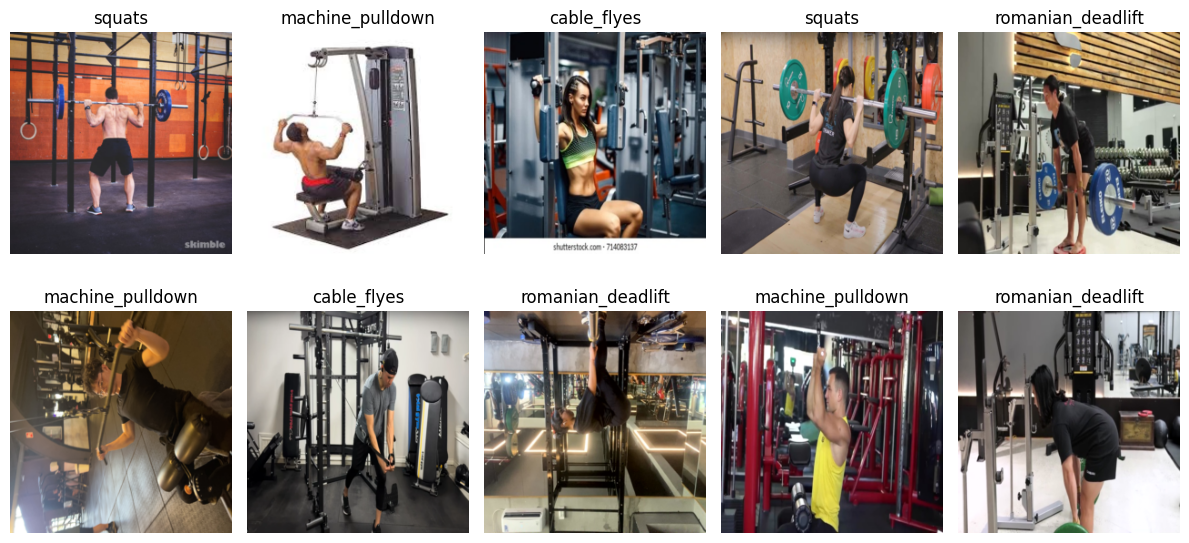

In [7]:
sample_size = 10
indices = T.randperm(len(dataset))[:sample_size]
sampled_images = [dataset[i][0] for i in indices]
sampled_labels = [dataset[i][1] for i in indices]
fig, axes = plt.subplots(nrows=int(sample_size/5), ncols=5, figsize=(12, 6))
for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()

In [8]:
class DataModule(L.LightningDataModule):
    def __init__(self, data, split=[.6, .2, .2], batch_size=32, num_workers=0):
        super().__init__()
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.train, self.val, self.test = D.random_split(self.data, self.split)

    def train_dataloader(self):
        return D.DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=False)
    
    def val_dataloader(self):
        return D.DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=False)
    
    def test_dataloader(self):
        return D.DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=False)


datamodule = DataModule(dataset)
datamodule.setup()

In [9]:
class ImageClassifierModel(L.LightningModule):
    def __init__(self, pretrained_model, num_classes, freeze_layers=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        if freeze_layers:
            for param in self.model.parameters(): 
                param.requires_grad = False
        self.model.fc = T.nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = T.nn.CrossEntropyLoss()
        self.accuracy = M.Accuracy(task="multiclass", num_classes=self.num_classes, average="none")
        self.precision = M.Precision(task="multiclass", num_classes=self.num_classes, average="none")
        self.recall = M.Recall(task="multiclass", num_classes=self.num_classes, average="none") 
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return T.optim.Adam(self.parameters(), lr=0.002) 

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        self.log("val_loss", self.criterion(logits, y))

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])


model = ImageClassifierModel(pretrained_model, num_classes=len(classes))

In [ ]:
logger = L.loggers.CSVLogger(save_dir=".")
stop = L.callbacks.early_stopping.EarlyStopping(monitor="val_loss", mode="min")
trainer = L.Trainer(max_epochs=-1, logger=logger, callbacks=[stop])
trainer.fit(model, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


NameError: name 'model' is not defined

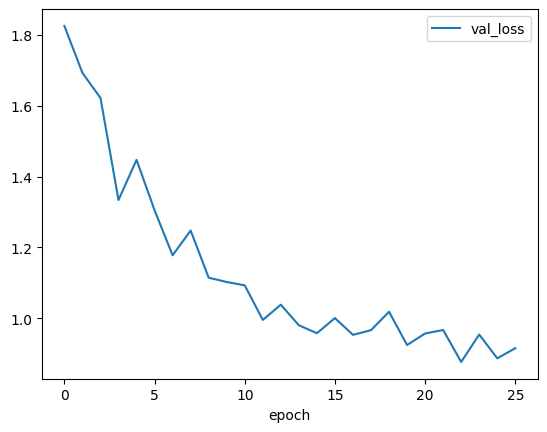

In [11]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

In [12]:
scores = trainer.test(model, datamodule=datamodule, verbose=False)
accuracies = [scores[0]["test_accuracy_class_" + str(i)] for i in range(len(classes))]
precisions = [scores[0]["test_precision_class_" + str(i)] for i in range(len(classes))]
recalls = [scores[0]["test_recall_class_" + str(i)] for i in range(len(classes))]
df = pandas.DataFrame({"class": classes, "accuracy": accuracies, "precision": precisions, "recall": recalls}).set_index("class")
df

C:\Users\yusuf\AppData\Roaming\Python\Python314\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 2/2 [00:02<00:00,  0.88it/s]


,accuracy,precision,recall
class,,,
cable_flyes,0.857143,0.857143,0.857143
incline_benchpress,0.818182,0.818182,0.818182
machine_pulldown,0.833333,0.833333,0.833333
pullup,0.923077,0.923077,0.923077
romanian_deadlift,1.000000,1.000000,1.000000
squats,0.888889,0.888889,0.888889


In [13]:
inference_folder = V.datasets.ImageFolder(inference_path, transform=transform)
inference_dataloader = D.DataLoader(inference_folder, batch_size=32, num_workers=int(os.cpu_count()/2), persistent_workers=True)
preds = trainer.predict(model, dataloaders=inference_dataloader)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


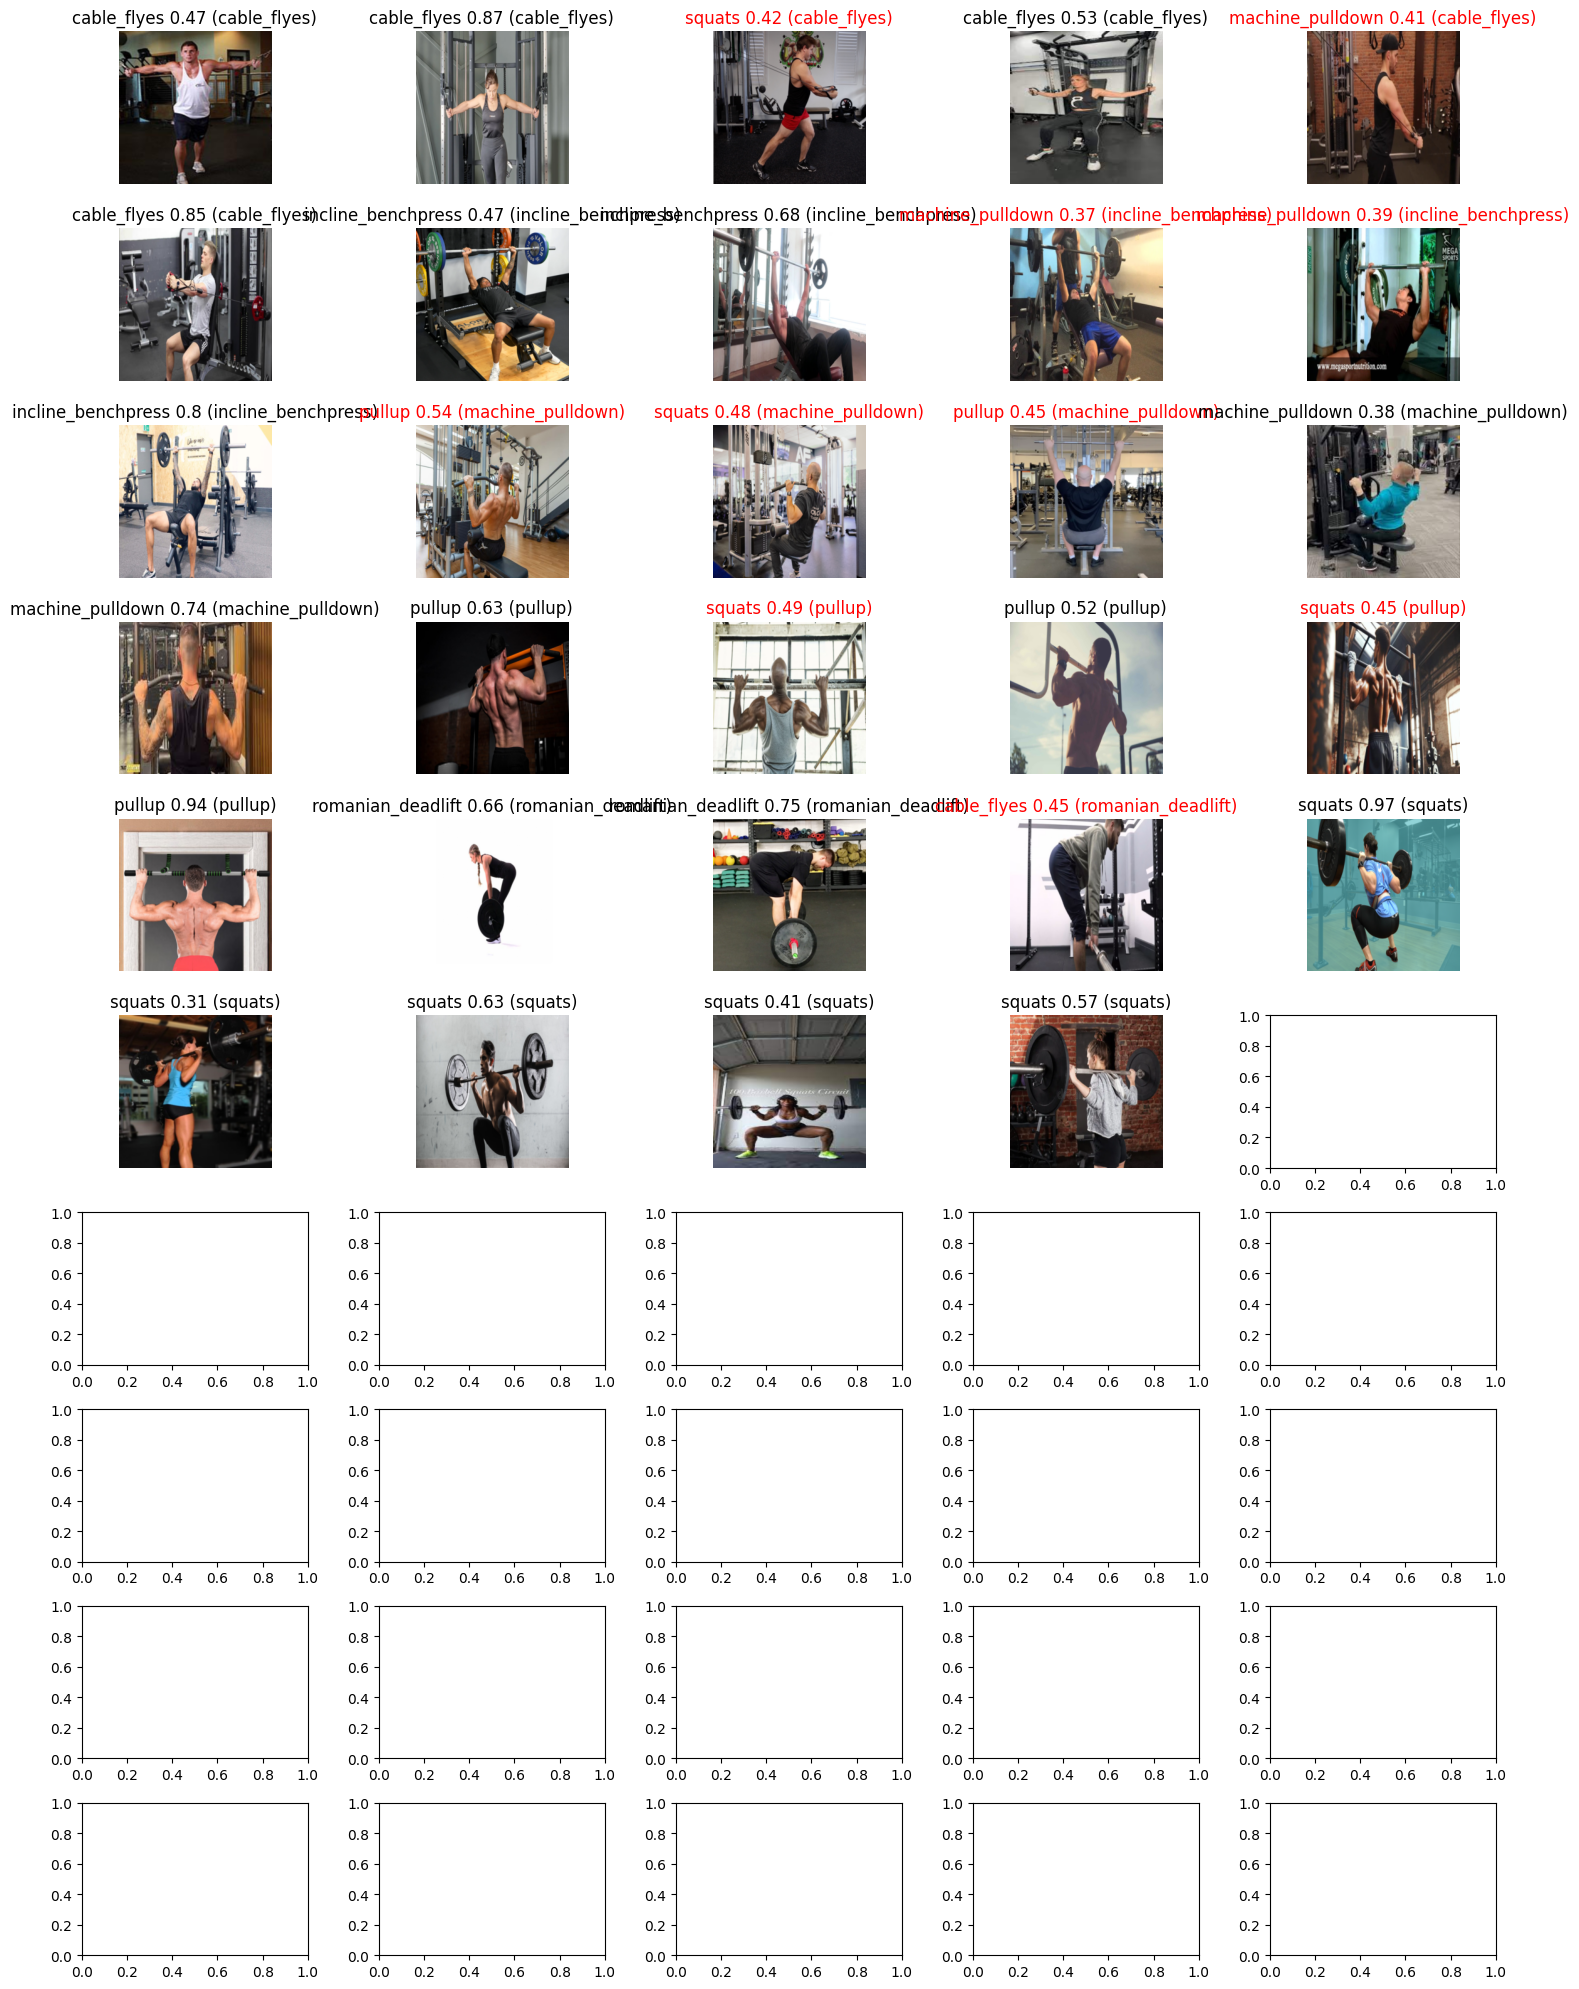

In [14]:
predictions = T.cat(preds)
images = T.cat([x for x, y in inference_dataloader])
labels = T.cat([y for x, y in inference_dataloader])

fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i, (image, truth, prediction) in enumerate(zip(images, labels, predictions)):
    probabilities = T.softmax(prediction, dim=0)
    pred_class = T.argmax(probabilities)
    pred_prob = probabilities[pred_class].item()
    pred_label = classes[pred_class]
    truth_label = classes[truth.item()]
    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_title(pred_label + " " + str(round(pred_prob,2)) + " ("+ truth_label+")", color="red" if pred_label != truth_label else "black")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

# model klaarmaken voor export om te gerbuiken in app

In [15]:
import torch as T
import torchvision as V

T.save(model.state_dict(), "model.pth")


Omdat ik de nieuwste vesie van python gebruik en de libraries nog achterlopen qua updates, heb ik in een aparte project de model.pth file die ik hier boven heb aangemaakt, omgezet naar een .tflite bestand. Hierdoor kan ik het AI-model gebruiken in mijn app

# Data uit de grafieken omzetten naar JSON zodat de data gebruikt kan worden om grafieken te maken binnen de app

In [21]:
import json
import os

# === 1. LOSS CURVE UIT METRICS.CSV ===
val_loss_values = metrics["val_loss"].dropna().tolist()

val_loss_values = [round(float(x), 5) for x in val_loss_values]

# === 2. ACCURACY PER CLASS ===
accuracies = [
    scores[0]["test_accuracy_class_" + str(i)]
    for i in range(len(classes))
]

accuracy = {}
for class_name, acc in zip(classes, accuracies):
    accuracy[class_name] = round(float(acc), 2)   # ← HIER AFGEROND OP 2 DECIMALEN


# === 3. DATASET DISTRIBUTION ===
dataset_distribution = {}
for class_name in classes:
    folder_path = os.path.join(data_path, class_name)
    dataset_distribution[class_name] = len([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.avif'))
    ])


# === 4. BOUW HET JSON OBJECT ===
stats = {
    "accuracy": accuracy,
    "loss_curve": val_loss_values,
    "dataset_distribution": dataset_distribution
}


# === 5. OPSLAAN ===
with open("model_stats.json", "w") as f:
    json.dump(stats, f, indent=4)

print("model_stats.json succesvol aangemaakt!")


model_stats.json succesvol aangemaakt!
